# Exploration of ablation results

(Note: a ton of the code in this notebook is super messy, the most useful bits have been moved to `runners/linear.py`)

In [2]:
from datasets import load_dataset
import torch
from safetensors.torch import load_file, save_file
import sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import random
sys.path.append("../")
from jacobian_saes.utils import load_pretrained, run_sandwich


In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


In [4]:
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

What's going on with that cluster? Why isn't everything just neatly on the line?

In [5]:
n_samples = 10_000

sae_pair, model, mlp_with_grads, layer = load_pretrained("lucyfarnik/jsaes_pythia70m2/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0")
k = sae_pair.cfg.activation_fn_kwargs["k"]

dataset = load_dataset("allenai/c4", "en", split="validation", streaming=True)
dataset = dataset.shuffle(seed=42)

generator = torch.Generator()
generator.manual_seed(42)

results = []
with torch.no_grad():
    with tqdm(total=n_samples) as pbar:
        for item in dataset:
            _, cache = model.run_with_cache(
                item["text"],
                stop_at_layer=layer + 1,
                names_filter=[sae_pair.cfg.hook_name],
            )
            acts = cache[sae_pair.cfg.hook_name][:, 1:]

            for act in acts[0, 1:]:
                jacobian, acts_dict = run_sandwich(sae_pair, mlp_with_grads, act)
                sae_acts1 = acts_dict["sae_acts1"]
                sae_acts2 = acts_dict["sae_acts2"]
                topk_indices1 = acts_dict["topk_indices1"]
                topk_indices2 = acts_dict["topk_indices2"]

                for _ in range(k):  # doesn't have to be k, this can be any number
                    # randint from 0 to k-1
                    out_idx, in_idx = torch.randint(0, k, (2,), generator=generator)

                    in_idx_in_d_sae = topk_indices1[in_idx]
                    out_idx_in_d_sae = topk_indices2[out_idx]

                    act_abl = act - sae_pair.get_W_dec(False)[in_idx_in_d_sae]
                    mlp_out_abl, _ = mlp_with_grads(act_abl)
                    sae_acts2_abl = sae_pair.encode(mlp_out_abl, True)

                    random.seed(42 + pbar.n * 1000)
                    results.append({
                        "id": ''.join([random.choice('0123456789abcdef') for _ in range(8)]),
                        "jac_el": jacobian[out_idx, in_idx],
                        "diff": sae_acts2_abl[out_idx_in_d_sae] - sae_acts2[out_idx_in_d_sae],
                        "act": act,
                        "in_feature_dir": sae_pair.get_W_dec(False)[in_idx_in_d_sae],
                        "in_feature_strength": sae_acts1[in_idx_in_d_sae],
                        "out_feature_strength": sae_acts2[out_idx_in_d_sae],
                        "out_idx_in_d_sae": out_idx_in_d_sae,
                    })

                    pbar.update(1)
                    if pbar.n >= n_samples:
                        break
                if pbar.n >= n_samples:
                    break
            if pbar.n >= n_samples:
                break


/Users/tz20913/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Research/Jacobian SAEs/notebooks/../jacobian_saes/sae_pair.py:148: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Loaded pretrained model pythia-70m-deduped into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 10000/10000 [00:34<00:00, 286.24it/s]


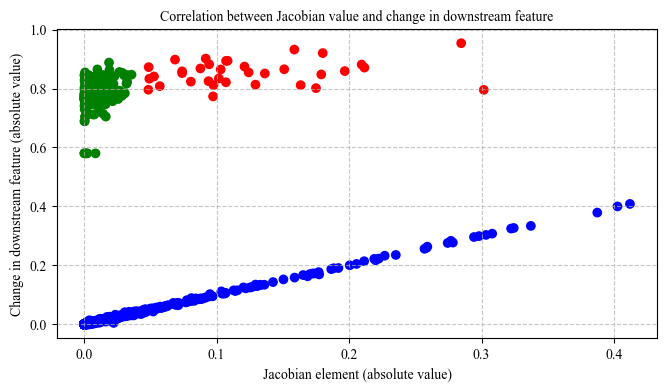

on line: 9753, in cluster: 212, outliers: 35


In [6]:
take_abs = True

jac_els = torch.tensor([r["jac_el"] for r in results])
diffs = torch.tensor([r["diff"] for r in results])

get_is_on_line = lambda jac_els, diffs: (jac_els + diffs).abs() < 0.1
get_is_in_cluster = lambda jac_els, diffs: (jac_els < 0.04) & (diffs < -0.5)

is_on_line = get_is_on_line(jac_els, diffs)
is_in_cluster = get_is_in_cluster(jac_els, diffs)
colors = torch.zeros(len(results))
colors[is_on_line] = 1
colors[is_in_cluster] = 2

if take_abs:
    jac_els.abs_()
    diffs.abs_()

# Create the scatter plot
plt.figure(figsize=(6.75, 4))  # This gives us roughly 800px width as in original

# Create scatter plot with custom colormap
scatter = plt.scatter(
    jac_els.cpu().numpy(),
    diffs.cpu().numpy(),
    c=colors.cpu().numpy(),
    cmap=LinearSegmentedColormap.from_list('custom', ['red', 'blue', 'green'])
)

# Set title and axis labels
plt.title('Correlation between Jacobian value and change in downstream feature')
plt.xlabel(f"Jacobian element{' (absolute value)' if take_abs else ''}")
plt.ylabel(f"Change in downstream feature{' (absolute value)' if take_abs else ''}")

# Style adjustments to match plotly_white template
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/not_local_expanded.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=jac_els.cpu().numpy(),
    y=diffs.cpu().numpy(),
    text=[r["id"] for r in results],
    marker=dict(color=colors.cpu().numpy(), colorscale=['red', 'blue', 'green']),
    mode='markers',
))
fig.update_layout(
    title='Correlation between Jacobian value and change in downstream feature',
    xaxis_title=f"Jacobian element{' (absolute value)' if take_abs else ''}",
    yaxis_title=f"Change in downstream feature{' (absolute value)' if take_abs else ''}",
    template='plotly_white',
    showlegend=False,
    width=800,
)
fig.show()


print(f"on line: {is_on_line.sum().item()}, in cluster: {is_in_cluster.sum().item()}, outliers: {(~is_in_cluster & ~is_on_line).sum().item()}")

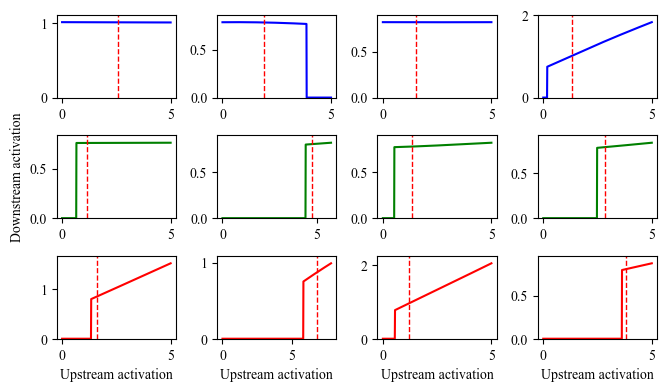

In [7]:
selected_ids = ["b8fda21e", "c3f70597", "c1a2a360", "d00f46cf",
                "f6a4b56d", "294aa0d4", "77bb8cf2", "2ba65476",
                "f87a7a7a", "c195ecd9", "179211ec", "b928b98e"]

def find_by_id(id: str):
    filtered = [r for r in results if r["id"] == id]
    if len(filtered) > 1:
        raise ValueError(f"Multiple results with the same ID ({id})")
    if len(filtered) == 0:
        raise ValueError(f"No results with the ID {id}")

    return filtered[0]

@torch.no_grad()
def get_act_relationship(feature_data: dict, max_upstream: int = 5, n_points: int = 1000):
    upstream_acts = torch.linspace(0, max_upstream, n_points,
                                   device=results[0]["act"].device).reshape(-1, 1)
    act_abl = feature_data["act"] - feature_data["in_feature_strength"] * feature_data["in_feature_dir"]
    act_range = upstream_acts * feature_data["in_feature_dir"] + act_abl.unsqueeze(0)
    mlp_out_range, _ = mlp_with_grads(act_range)
    sae_acts2_range = sae_pair.encode(mlp_out_range, True)
    downstream_acts = sae_acts2_range[:, feature_data["out_idx_in_d_sae"]]

    return upstream_acts.flatten(), downstream_acts


def plot_feature_relationship(selected_id: str, ax, idx):
    feature_data = find_by_id(selected_id)

    is_on_line = get_is_on_line(feature_data["jac_el"], feature_data["diff"])
    is_in_cluster = get_is_in_cluster(feature_data["jac_el"], feature_data["diff"])
    color = "blue" if is_on_line else "green" if is_in_cluster else "red"

    upstream_acts, downstream_acts = get_act_relationship(feature_data,
                                                          max(5, feature_data["in_feature_strength"]+1))


    ax.plot(upstream_acts.cpu().numpy(), 
            downstream_acts.cpu().numpy(), 
            color=color)
    
    # Add the vertical dashed line
    ax.axvline(x=feature_data["in_feature_strength"].cpu().item(), 
                color='red', 
                linestyle='--', 
                linewidth=1)
    
    # Customize the subplot
    if idx > 7:
        ax.set_xlabel('Upstream activation')
    if idx == 4:
        ax.set_ylabel('Downstream activation')
    ax.set_ylim(0, max(downstream_acts.cpu().numpy()) * 1.1)
        
    # fig = go.Figure()
    # fig.add_trace(go.Scatter(
    #     x=upstream_acts.cpu().numpy(),
    #     y=downstream_acts.cpu().numpy(),
    #     mode='lines',
    #     line=dict(color=color),
    # ))
    # # add a dashed vertical line indicating where in_feature_strength is on the x axis
    # fig.add_shape(
    #     type="line",
    #     x0=feature_data["in_feature_strength"],
    #     y0=downstream_acts.min(),
    #     x1=feature_data["in_feature_strength"],
    #     y1=downstream_acts.max(),
    #     line=dict(
    #         color="red",
    #         width=1,
    #         dash="dash",
    #     ),
    # )

    # fig.update_layout(
    #     title=f'Change in downstream feature with respect to change in input feature ({selected_id})',
    #     xaxis_title="Upstream activation",
    #     yaxis_title="Downstream activation",
    #     template='plotly_white',
    #     showlegend=False,
    #     width=800,
    # )
    # fig.show()

fig, axes = plt.subplots(3, 4, figsize=(6.75, 4))
axes_flat = axes.flatten()

for idx, id in enumerate(selected_ids):
    plot_feature_relationship(id, axes_flat[idx], idx)

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/not_local_functions.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


## How many features pairs are there where the connection follows this JumpReLU pattern?

In [8]:
def is_jump_relu(feature_data: dict, tolerance=1e-2):
    xs, ys = get_act_relationship(feature_data,
                                  max(5, feature_data["in_feature_strength"]+1),
                                  n_points=100)
    
    # Check for zero region
    zero_region = (ys == 0)
    if torch.any(zero_region):
        # Find the bounds of the zero region
        zero_indices = torch.where(zero_region)[0]
        zero_start, zero_end = xs[zero_indices[0]], xs[zero_indices[-1]]

        # Make sure the zero region is continuous
        if not (ys[zero_indices[0]:zero_indices[-1]] == 0).all():
            return False, {"reason": "zero region not continuous"}

        # Make sure it includes the start or the finish
        if not ys[0] == 0 and not ys[-1] == 0:
            return False, {"reason": "zero region doesn't include start or finish"}

        # Check linearity outside the zero region
        linear_region_mask = (xs > zero_end) | (xs < zero_start)
        linear_x = xs[linear_region_mask]
        linear_y = ys[linear_region_mask]

        zero_start, zero_end = zero_start.item(), zero_end.item()
    else:
        return False, {"reason": "no zero region"}

    if linear_x.numel() < 2:
        return False, {"reason": "no linear region"}

    # Fit a linear model to the outside region (y = slope * x + intercept)
    A = torch.stack([linear_x, torch.ones_like(linear_x)], dim=1)  # [x, 1]
    lstsq = torch.linalg.lstsq(A.cpu(), linear_y.unsqueeze(1).cpu())  # Linear regression
    slope = lstsq.solution[0].item()
    intercept = lstsq.solution[1].item()

    # Check if residuals are within tolerance
    residuals = linear_y - (slope * linear_x + intercept)
    is_linear = torch.all(torch.abs(residuals) < tolerance)

    if is_linear:
        return True, {
            "zero_region": (zero_start, zero_end),
            "linear_slope": slope,
            "linear_intercept": intercept,
        }
    else:
        return False, {"reason": "not linear outside zero region"}

for id in selected_ids:
    print(id, is_jump_relu(find_by_id(id)))

b8fda21e (False, {'reason': 'no zero region'})
c3f70597 (True, {'zero_region': (3.8888888359069824, 5.0), 'linear_slope': -0.00462231645360589, 'linear_intercept': 0.7914016842842102})
c1a2a360 (False, {'reason': 'no zero region'})
d00f46cf (False, {'reason': 'not linear outside zero region'})
f6a4b56d (True, {'zero_region': (0.0, 0.6060606241226196), 'linear_slope': 0.0005863556289114058, 'linear_intercept': 0.759284496307373})
294aa0d4 (True, {'zero_region': (0.0, 4.353287220001221), 'linear_slope': 0.014959574677050114, 'linear_intercept': 0.7389886975288391})
77bb8cf2 (True, {'zero_region': (0.0, 0.5050504803657532), 'linear_slope': 0.011076574213802814, 'linear_intercept': 0.7661161422729492})
2ba65476 (True, {'zero_region': (0.0, 2.4747474193573), 'linear_slope': 0.02253808081150055, 'linear_intercept': 0.7193738222122192})
f87a7a7a (True, {'zero_region': (0.0, 1.313131332397461), 'linear_slope': 0.19881939888000488, 'linear_intercept': 0.5372552275657654})
c195ecd9 (True, {'zero

In [9]:
n_samples_to_check = 10_000

jump_relu_results = []
for r in tqdm(results[:n_samples_to_check]):
    jump_relu_results.append(is_jump_relu(r)[0])
f"{torch.tensor(jump_relu_results).float().sum().int():,} out of {n_samples_to_check:,} are jump relus"

100%|██████████| 10000/10000 [01:23<00:00, 120.13it/s]


'954 out of 10,000 are jump relus'

## How many are linear?

In [12]:
def is_linear(feature_data: dict, tolerance=1e-2):
    xs, ys = get_act_relationship(feature_data,
                                  max(5, feature_data["in_feature_strength"]+1),
                                  n_points=100)
    

    # Fit a linear model to the outside region (y = slope * x + intercept)
    A = torch.stack([xs, torch.ones_like(xs)], dim=1)  # [x, 1]
    lstsq = torch.linalg.lstsq(A.cpu(), ys.unsqueeze(1).cpu())  # Linear regression
    slope = lstsq.solution[0].item()
    intercept = lstsq.solution[1].item()

    # Check if residuals are within tolerance
    residuals = ys - (slope * xs + intercept)
    is_linear = torch.all(torch.abs(residuals) < tolerance)

    if is_linear:
        return True, {
            "linear_slope": slope,
            "linear_intercept": intercept,
        }
    else:
        return False, {"reason": "not linear"}

for id in selected_ids:
    print(id, is_linear(find_by_id(id)))

b8fda21e (True, {'linear_slope': -0.0007775293197482824, 'linear_intercept': 1.0153331756591797})
c3f70597 (False, {'reason': 'not linear'})
c1a2a360 (True, {'linear_slope': -1.7695834685582668e-05, 'linear_intercept': 0.8212893605232239})
d00f46cf (False, {'reason': 'not linear'})
f6a4b56d (False, {'reason': 'not linear'})
294aa0d4 (False, {'reason': 'not linear'})
77bb8cf2 (False, {'reason': 'not linear'})
2ba65476 (False, {'reason': 'not linear'})
f87a7a7a (False, {'reason': 'not linear'})
c195ecd9 (False, {'reason': 'not linear'})
179211ec (False, {'reason': 'not linear'})
b928b98e (False, {'reason': 'not linear'})


In [10]:
n_samples_to_check = 10_000

linear_results = []
for r in tqdm(results[:n_samples_to_check]):
    linear_results.append(is_linear(r)[0])
f"{torch.tensor(linear_results).float().sum().int():,} out of {n_samples_to_check:,} are linear"

  0%|          | 0/10000 [00:00<?, ?it/s]


NameError: name 'is_linear' is not defined

## What do the other IDs look like

In [13]:
is_linear_count = 0
is_jump_relu_count = 0
other_ids = []
for r in tqdm(results[:n_samples_to_check]):
    if is_linear(r)[0]:
        is_linear_count += 1
    elif is_jump_relu(r)[0]:
        is_jump_relu_count += 1
    else:
        other_ids.append(r["id"])
is_linear_count, is_jump_relu_count, len(other_ids)

100%|██████████| 10000/10000 [01:21<00:00, 122.70it/s]


(8634, 954, 412)

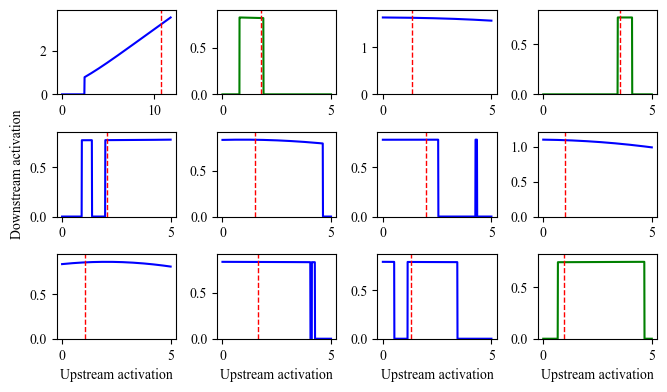

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(6.75, 4))
axes_flat = axes.flatten()

# randomly pick 12 ids from other_ids (deterministically
random.seed(42)
random.shuffle(other_ids)
other_ids_subset = other_ids[:12]

for idx, id in enumerate(other_ids_subset):
    plot_feature_relationship(id, axes_flat[idx], idx)

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/nonlinear_functions.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Second derivative

In [63]:
def compute_second_derivative(xs, ys):
    h_forward = xs[1:] - xs[:-1]  
    first_deriv_forward = (ys[1:] - ys[:-1]) / h_forward
    h_central = (xs[2:] - xs[:-2]) / 2
    second_deriv = (first_deriv_forward[1:] - first_deriv_forward[:-1]) / h_central
    
    return second_deriv, xs[1:-1]  

second_derivs = []
for feature_data in tqdm(results[:n_samples_to_check]):
    upstream_acts, downstream_acts = get_act_relationship(feature_data,
                                                          max(5, feature_data["in_feature_strength"]+1))
    second_deriv, xs = compute_second_derivative(upstream_acts, downstream_acts)
    second_derivs.append(second_deriv)
second_derivs = torch.stack(second_derivs)

100%|██████████| 10000/10000 [06:13<00:00, 26.78it/s]


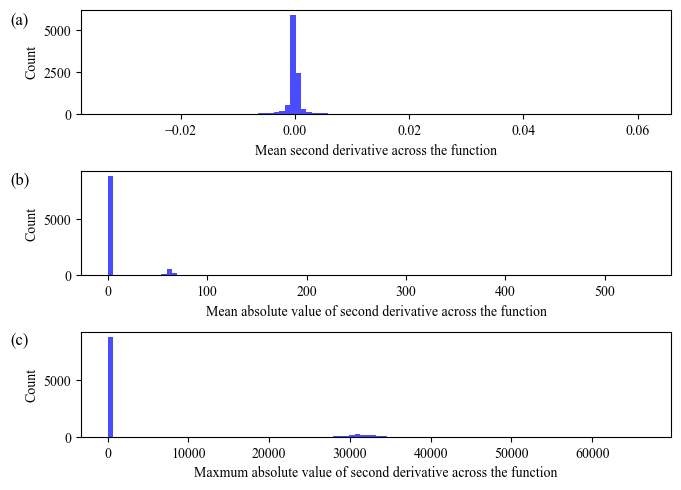

In [108]:
def make_der_hist(second_derivs, ax, take_abs: bool = False, take_max: bool = False):
    if take_abs:
        der = second_derivs.abs()
    else:
        der = second_derivs
    
    if take_max:
        der = der.max(1).values
    else:
        der = der.mean(1)
    
    if not take_abs and not take_max:
        # Excluding two outliers
        der = der[der > -1]

    ax.hist(der.cpu().numpy(), bins=100, color='blue', alpha=0.7)
    if take_max:
        ax.set_xlabel(f'Maxmum {"absolute value of " if take_abs else ""}second derivative across the function')
    else:
        ax.set_xlabel(f'Mean {"absolute value of " if take_abs else ""}second derivative across the function')
    ax.set_ylabel('Count')


fig, axes = plt.subplots(3, 1, figsize=(6.75, 5))
make_der_hist(second_derivs, axes[0])
make_der_hist(second_derivs, axes[1], take_abs=True)
make_der_hist(second_derivs, axes[2], take_abs=True, take_max=True)

plt.figtext(0, 0.94, '(a)', fontsize=12)
plt.figtext(0, 0.62, '(b)', fontsize=12)
plt.figtext(0, 0.3, '(c)', fontsize=12)

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/second_derivative_distribution.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### What about only looking at the second-order derivatives of the non-linear functions

In [105]:
second_derivs_nonlinear = []
for id in tqdm(other_ids):
    feature_data = find_by_id(id)

    upstream_acts, downstream_acts = get_act_relationship(feature_data,
                                                          max(5, feature_data["in_feature_strength"]+1))
    second_deriv, xs = compute_second_derivative(upstream_acts, downstream_acts)
    second_derivs_nonlinear.append(second_deriv)
second_derivs_nonlinear = torch.stack(second_derivs_nonlinear)

100%|██████████| 269/269 [00:14<00:00, 18.67it/s]


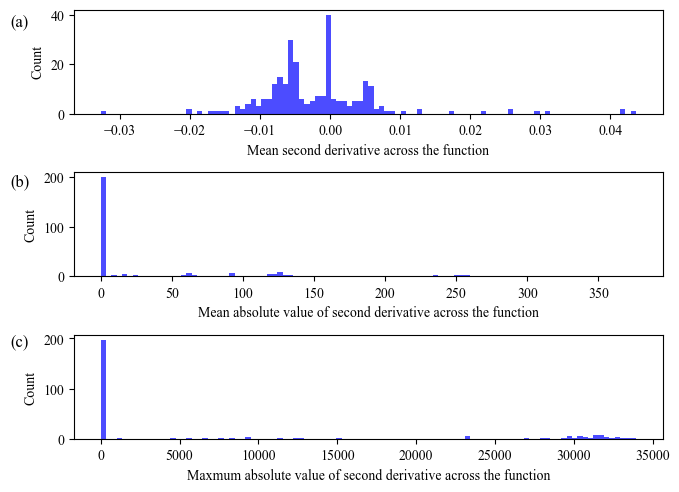

In [109]:
fig, axes = plt.subplots(3, 1, figsize=(6.75, 5))
make_der_hist(second_derivs_nonlinear, axes[0])
make_der_hist(second_derivs_nonlinear, axes[1], take_abs=True)
make_der_hist(second_derivs_nonlinear, axes[2], take_abs=True, take_max=True)

plt.figtext(0, 0.94, '(a)', fontsize=12)
plt.figtext(0, 0.62, '(b)', fontsize=12)
plt.figtext(0, 0.3, '(c)', fontsize=12)

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/second_derivative_distribution_nonlinear.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## How often are SAE feature activations actually in the range we're testing (rather than being at the upper edge of the range)?

In [237]:
feature_strengths = torch.tensor([r["in_feature_strength"] for r in results])
(feature_strengths < 4).float().mean(), feature_strengths.median()

(tensor(0.9154), tensor(1.6054))

## Pick a few examples from each class (linear, JumpReLU, and other)
A viewer that lets you sample functions, then add selected ones to a list, then export them to be used in `final_charts.ipynb`

In [15]:
reset_list = False
if reset_list:
    linear_f_data = []
    jumprelu_f_data = []
    other_f_data = []

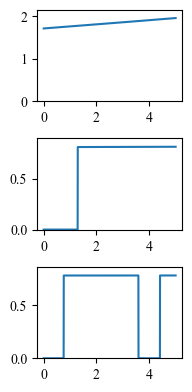

In [161]:
func_xs = torch.linspace(0, 5, 1000)
new_linear_f_data = None
new_jumprelu_f_data = None
new_other_f_data = None
while new_linear_f_data is None or new_jumprelu_f_data is None or new_other_f_data is None:
    feature_data = random.choice(results)

    if feature_data["in_feature_strength"]+1 > 5:
        continue

    if is_linear(feature_data)[0]:
        if new_linear_f_data is not None:
            continue
        else:
            func_class = "linear"
    elif is_jump_relu(feature_data)[0]:
        if new_jumprelu_f_data is not None:
            continue
        else:
            func_class = "jumprelu"
    else:
        if new_other_f_data is not None:
            continue
        else:
            func_class = "other"

    _, ys = get_act_relationship(feature_data, 5)
    ys = ys.cpu()
    if (ys.max() - ys.min()).abs() < 0.1: continue
    if func_class == "linear":
        new_linear_f_data = ys
    elif func_class == "jumprelu":
        new_jumprelu_f_data = ys
    else:
        new_other_f_data = ys


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(2, 4))

ax1.plot(func_xs, new_linear_f_data)
ax1.set_ylim(0, max(new_linear_f_data) * 1.1)
ax2.plot(func_xs, new_jumprelu_f_data)
ax2.set_ylim(0, max(new_jumprelu_f_data) * 1.1)
ax3.plot(func_xs, new_other_f_data)
ax3.set_ylim(0, max(new_other_f_data) * 1.1)


# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.show()


In [119]:
linear_f_data.append(new_linear_f_data)

In [89]:
jumprelu_f_data.append(new_jumprelu_f_data)

In [98]:
other_f_data.append(new_other_f_data)

In [120]:
len(linear_f_data), len(jumprelu_f_data), len(other_f_data)

(5, 5, 5)

In [121]:
# export using safetensors
tensors_dict = {
    "xs": func_xs,
    "linear_ys": torch.stack(linear_f_data),
    "jumprelu_ys": torch.stack(jumprelu_f_data),
    "other_ys": torch.stack(other_f_data),
}

# Commented out to avoid accidentally overwriting data
save_file(tensors_dict, "../results/function_examples.safetensor")


# Examples of linear, JumpReLU, and other functions

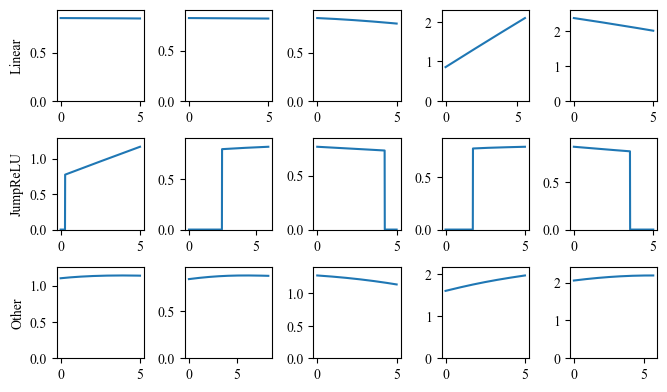

In [20]:
def does_func_move(feature_data):
    _, ys = get_act_relationship(feature_data,
                                 max(5, feature_data["in_feature_strength"]+1),
                                 n_points=10)
    return (ys[-1] - ys[0]).abs() > 0.1

def add_func_plot(feature_data, ax):
    xs, ys = get_act_relationship(feature_data, max(5, feature_data["in_feature_strength"]+1))
    ax.plot(xs.cpu().numpy(), ys.cpu().numpy())
    ax.set_ylim(0, max(ys.cpu().numpy()) * 1.1)
        
linear_examples = []
jumprelu_examples = []
other_examples = []
random.shuffle(results)
for r in results:
    if is_linear(r)[0]:
        if len(linear_examples) > 2 and not does_func_move(r):
            continue
        if len(linear_examples) < 5:
            linear_examples.append(r)
    elif is_jump_relu(r)[0]:
        if len(jumprelu_examples) > 2 and not does_func_move(r):
            continue
        if len(jumprelu_examples) < 5:
            jumprelu_examples.append(r)
    else:
        if len(other_examples) > 2 and not does_func_move(r):
            continue
        if len(other_examples) < 5:
            other_examples.append(r)
    if len(linear_examples) >= 5 and len(jumprelu_examples) >= 5 and len(other_examples) >= 5:
        break


fig, axes = plt.subplots(3, 5, figsize=(6.75, 4))

for func, ax in zip(linear_examples, axes[0]):
    add_func_plot(func, ax)
for func, ax in zip(jumprelu_examples, axes[1]):
    add_func_plot(func, ax)
for func, ax in zip(other_examples, axes[2]):
    add_func_plot(func, ax)

axes[0][0].set_ylabel("Linear")
axes[1][0].set_ylabel("JumpReLU")
axes[2][0].set_ylabel("Other")

# Adjust layout
plt.tight_layout(pad=1.0)

# Show the plot
plt.savefig('./charts/func_examples.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()